# Motivation

The data set that is considered in this document is one of airports and routes between airports. The specification of the data set and where it was downloaded from can be found in the readme of the project's repository: 
https://github.com/OliverFlecke/02805-Social-Graphs-and-Interactions-Project/blob/master/README.md

Both the *airports* and *routes* data set is downloaded seperately and some clean up was done on the data.

These data set were chosen since we found the interconnection of all parts of world through air travel interesting. Furthermore these datasets were the most easily accesible. There were other data sets, but some of them required payment and thus they were dismissed.

The goal were partly to create some statistics and visualizations that the user could relate to. I.e. how are airports connected through out the world, which airports tend to have more connections around the world and what characteristics affect the overall experience of an airport. Air travel is something the end user most likely will have experienced, so partly the goal was also to inform the end user about a topic they have experienced, but might not have considered in detail.

The remainder of the document first describes some basic stats of the data set. Afterwards various more advanced statistics are done on the graph, such as community detection, shortest paths, centrality measures and sentiment analysis done on the different airports combined with the analysis of the graph.

# Basic Stats

## Importing data

Initially, the data is loaded in. The *routes.csv* file contains the cleaned data set on all routes between the airports that are stored in the *airports.csv* file.

In [1]:
import pandas as pd

In [2]:
routes_df = pd.read_csv("data/routes.csv")
airports_df = pd.read_csv("data/airports.csv")

In [3]:
airports_by_iata_df = airports_df.groupby("IATA")

## Creating a directed multigraph

In [4]:
import networkx as nx

In [5]:
airport_nodes = list(airports_by_iata_df.groups)

In [6]:
#Ordering matches source and destination airport.
airport_src = list(routes_df["Source airport"])
airport_dest = list(routes_df["Destination airport"])

Due to some routes having an invalid source/destination, due to the airport not existing in the airport dataset, these routes are removed. The remaining routes and airports are added to the graph.

In [7]:
airport_routes_digraph = nx.MultiDiGraph()

airport_routes_digraph.add_nodes_from(airport_nodes)

edges = [(airport_src[i],airport_dest[i]) for i in range(len(airport_src))
        if airport_src[i] in airport_nodes and airport_dest[i] in airport_nodes]

airport_routes_digraph.add_edges_from(edges);

## Plotting the graph

In [8]:
import matplotlib.pyplot as plt

Methods are the defined for getting longitude and latitudes for different airports. This is used to determine the location of the nodes when plotting the graph.

In [9]:
def getLongitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Longitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

def getLatitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Latitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0


In [10]:
positions = {}

for node in airport_routes_digraph.nodes:
    positions.update({
        node: (getLongitudeForIATA(airports_df,node), 
               getLatitudeForIATA(airports_df,node))
    })    

When plotting the graph axes are removed.

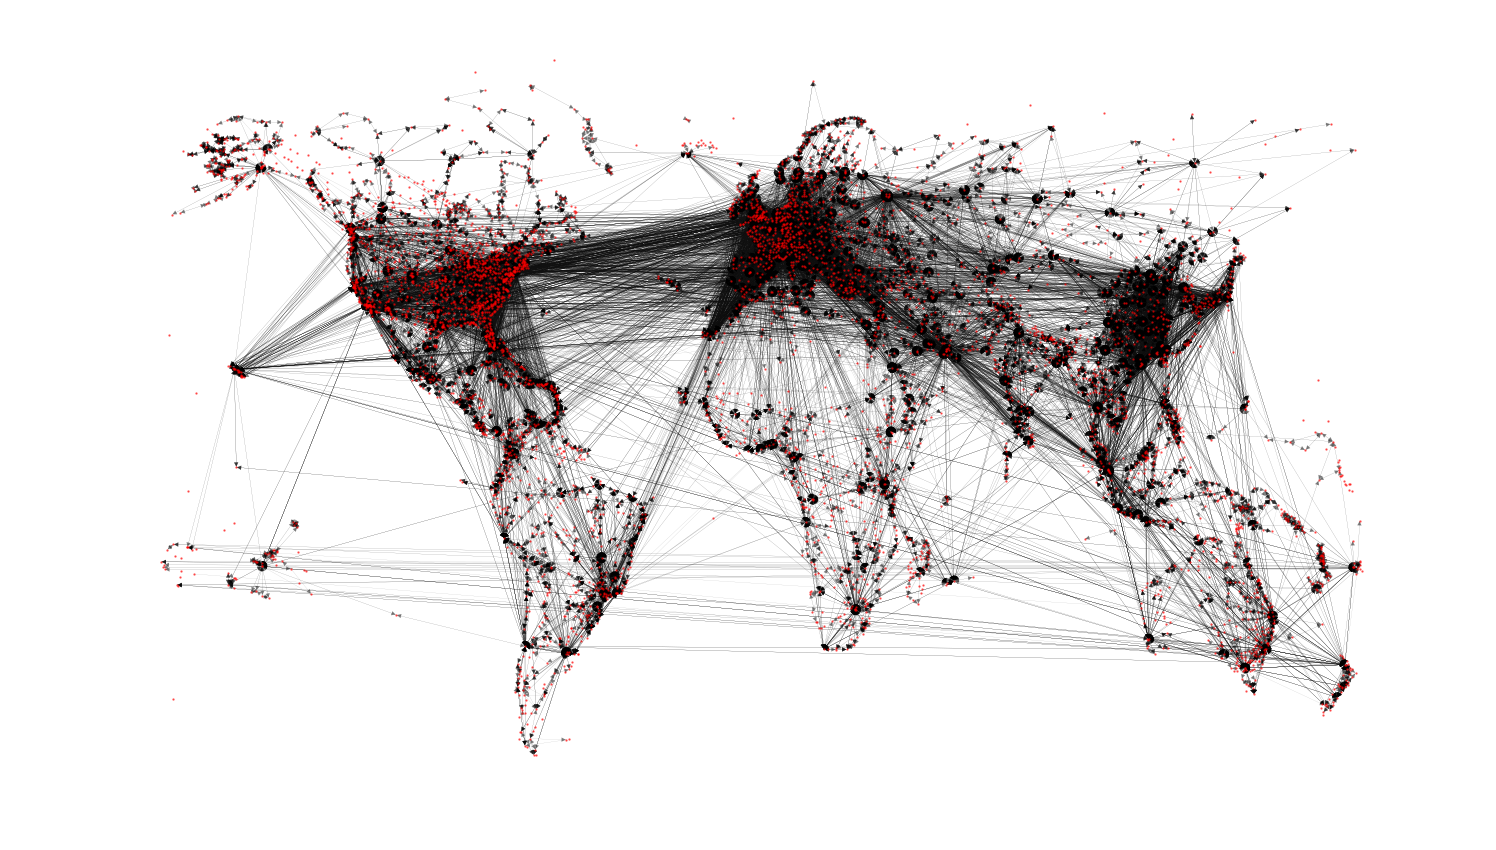

In [11]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))

plt.axis('off')
fig.savefig("output/airportgraph.png", transparent=True, bbox_inches='tight')

In [12]:
"The graph has " + str(len(airport_routes_digraph.nodes)) + " nodes."

'The graph has 5653 nodes.'

In [13]:
"The graph has " + str(len(airport_routes_digraph.edges)) + " edges."

'The graph has 66067 edges.'

As can be noted, the graph is rather large. The large amount of edges compared to nodes is expected considering we're dealing with airports. Airports tend to be very well connected to each other, and even smaller airports tend to offer a fair amount of flights to different destinations.

In the following, the degree distribution of the graph is plotted regularly and as a loglog plot.

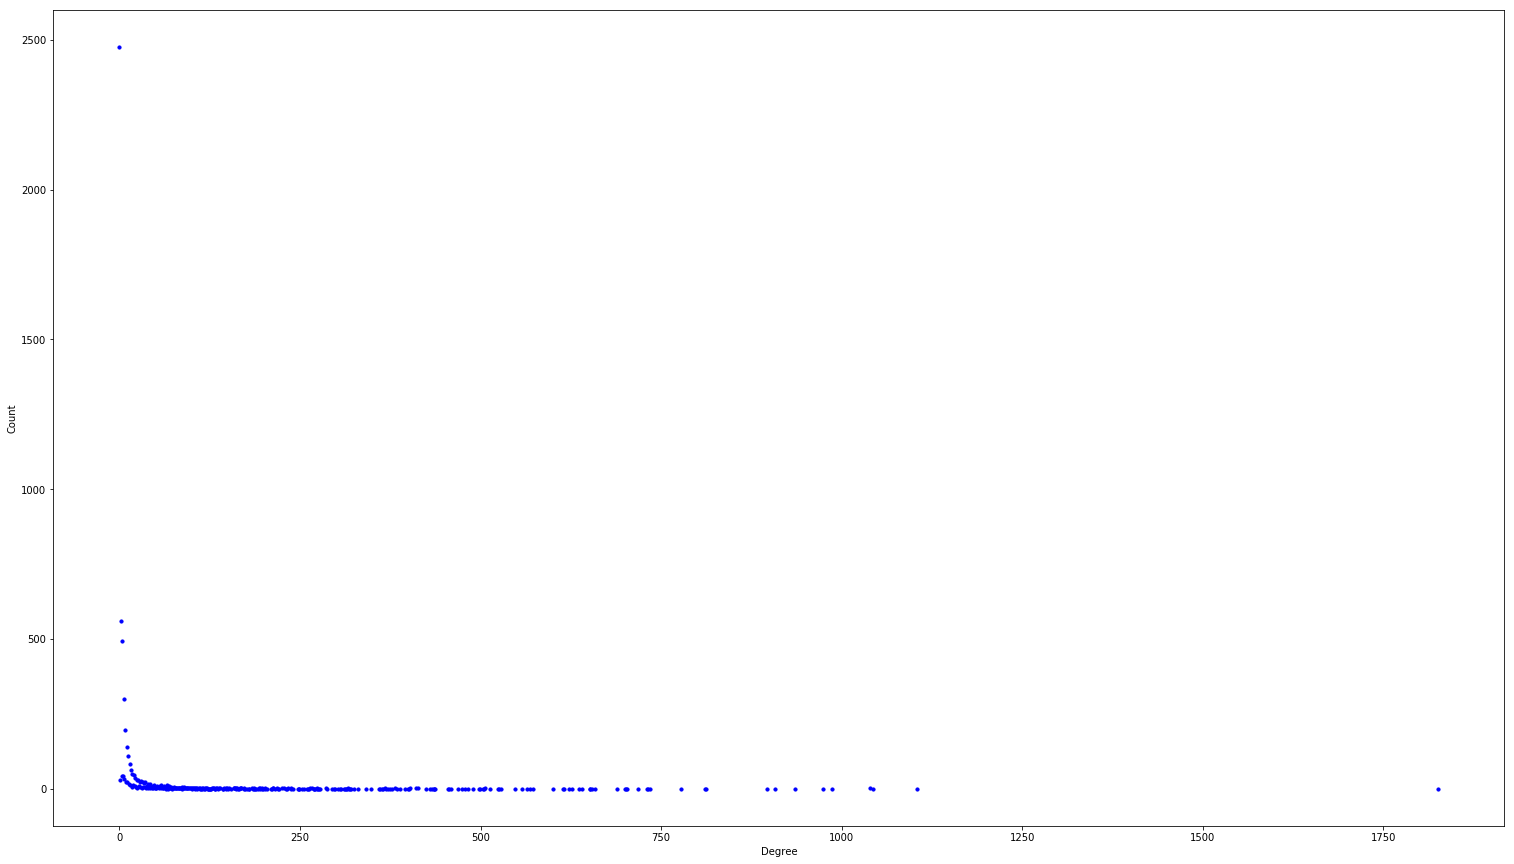

In [14]:
import collections

degreeforeach = sorted([d for n,d in airport_routes_digraph.degree], reverse=True)
degreeCount = collections.Counter(degreeforeach)
degrees, count = zip(*degreeCount.items())
fig = plt.figure(figsize=(26,15))
plt.scatter(degrees, count, s=10, color='b')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('output/regularplot.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

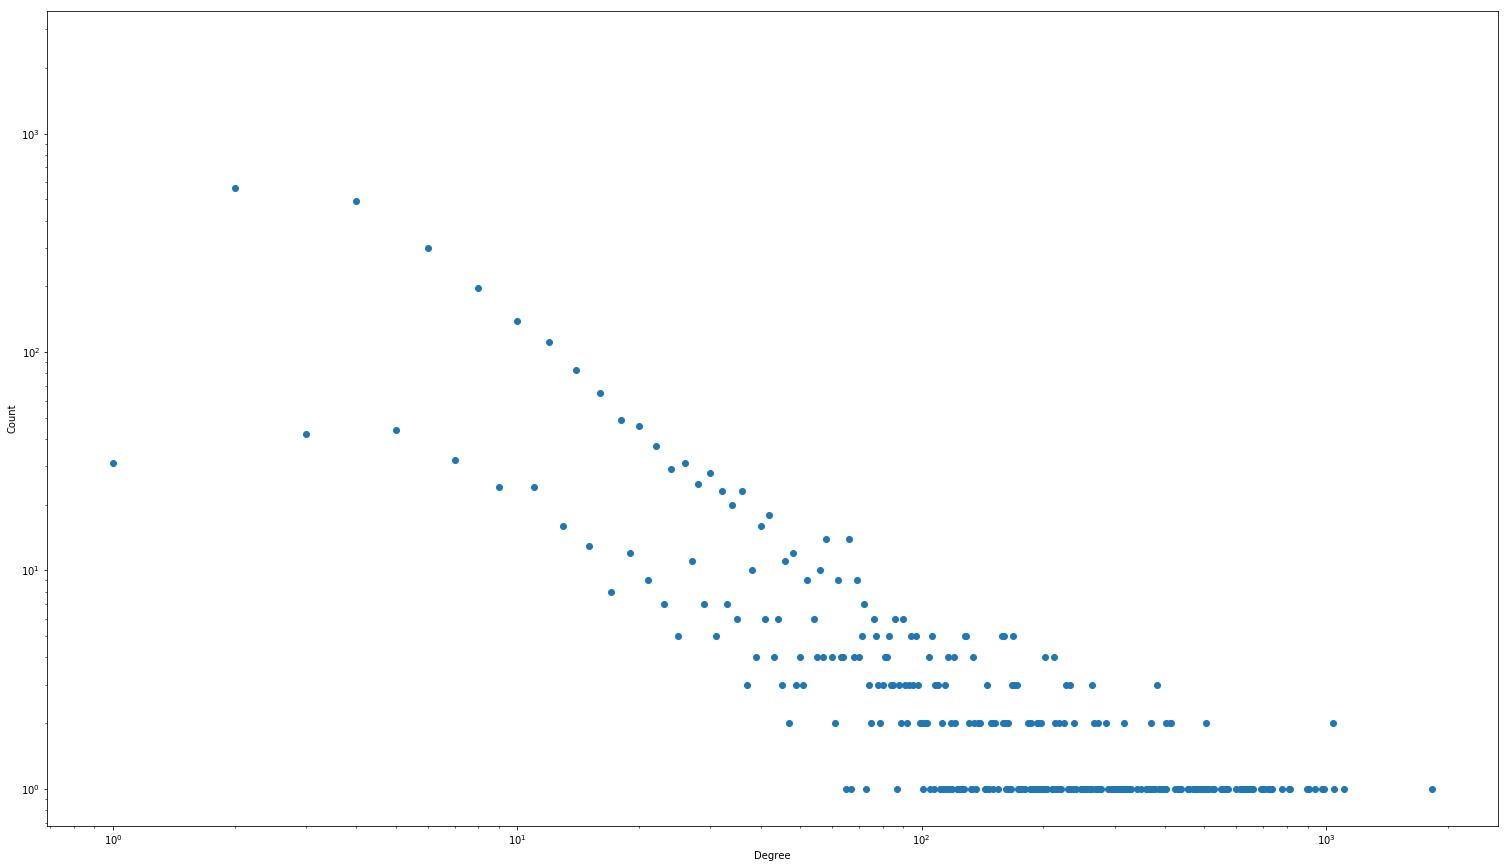

In [15]:
plt.clf()
fig = plt.figure(figsize=(26,15))
plt.loglog(degrees, count,'o')
plt.ylabel("Count")
plt.xlabel("Degree")

fig.savefig('output/powerlawplot.png', bbox_inches='tight')

## Analysing the loglog plot

The above loglog plot could be interpreted as the network consisting of two sub graphs that are scale-free. This is however not the case, as the graph does not contain any major sub graphs that are disconnected from the main graph. This will be further considered later, when considering longest shortest paths.

If the loglog plot is further considered, it can be noted that 30 airports have only 1 route. Remembering that the graph is directed, this does not make much sense, since it would be expected that an airport has atleast two routes. 

**Consdering airports with only route**

The airports with only one route are the following:

In [16]:
print([a for (a,i) in list(airport_routes_digraph.degree()) if i is 1])


['AGN', 'BVS', 'CMP', 'DLZ', 'ELV', 'FMI', 'IGG', 'IUE', 'JQE', 'KPV', 'KUK', 'KYK', 'KZI', 'LJA', 'LUR', 'MLY', 'MSW', 'PIP', 'PTH', 'PTJ', 'PTU', 'SIC', 'SLQ', 'STZ', 'SXX', 'TLJ', 'TTA', 'TUA', 'UII', 'VDA', 'XMS']


MLY is the Manley Hot Springs Airport which is located in Alaska, and has a single grass strip. Since the routes dataset focuses mostly on commerical traffic, the smaller airports tend to not be included. These smaller airport tend to be used for general aviation and scheduled commercial flights. 

There are however some airports, such as KPV, which is a larger national airport in the US, which in reality has a fair amount of flights, but in the dataset doesn't have any. 

There are also many airports that have degree zero.

In [17]:
str(len([a for (a,i) in list(airport_routes_digraph.degree()) if i is 0])) + " airports have degree 0."

'2474 airports have degree 0.'

The fact that there are many airports with degree zero and some have degree one indicates that the routes data set is incomplete and only contains more popular flights, but the amount of data is still sufficient for a meaningful analysis.

Also, remembering that some routes were removed due to invalid source or desintation airports, it could be the case that some of the airports for the routes were incorrectly added to the routes dataset. Thus some routes have been removed leading to some airports only having one route. Generally, this has to be kept in mind when considering the degree for all airports.

**Further considerations**

Further, it can be considered how around 500 airports have degree 2 and 3. These are very small airports with very little traffic. As expected in a scale free network, which is what the network clearly is, there are much fewer airports with high degree.

The way airlines like to design their routes is by focusing around having a central hub. This is an airport that offers a large amount of different routes to many smaller airports from the hub. Thus if a traveller were to go a long distance, they would first take a smaller flight to a hub, from where they would be transported to their desired location. You therefore end up with a lot of airports with fewer routes (generally routes where the destination is a hub) and fewer airports (hubs) with a large amount of routes.

# Tools, theory and analysis

The overall idea with this section is to perform several analysis steps. For each of these steps, the idea of the step is explained, the tools are explained and applied and lastly the results are discussed.

The following analysis steps were performed:

- Community Detection
- Shortest Paths
- Centrality Measures
- Tweets Sentiments
- Sentiment and Graph Analysis

The point of the sections *Community Detection* and *Shortest Paths* is to get an overview and understanding of the graph and how air traffic is structured. 

*Centrality Measures* and *Tweets Sentiments* are there, such that in the former case an understanding of which airports play a big role connecting the world is achieved. In the latter case, sentiment analysis is done to get an idea of what kind of language is used in the different airports around the world.

The last section, *Sentiment and Graph Analysis*, ties the above sections together to attempt to find a relation between the sentiment of the different airports and characteristics of the airports. The thought is that this should give an idea about why travellers prefer some airports over others.

## Community Detection

As mentioned earlier, the idea with this analysis step is to get an idea of how air traffic is structured. Do the airlines tend to fly their airplanes to many smaller destinations? Or perhaps they fly their passengers in bulk one or two specific destinations and pass them on from there? These are things to consider and are also relevant when considering why passengers prefer some airports over others.

**Tools**

This section first uses the [community](https://github.com/taynaud/python-louvain) package, which is used to find the optimal community partition for the graph.

Following this custom communities are made, where the modularity for the custom communities and the best community partition is considered.

### Communities

<img src="https://raw.githubusercontent.com/OliverFlecke/02805-Social-Graphs-and-Interactions-Project/master/modularity.png" width=300>

A community is subgraph in a network, where the nodes in the community are densely connecte to each other. A community can in general be considered *strong* or *weak*. 

A *strong* community is a community, where each of the nodes in the community are more connected to other nodes in the community rather than the remaining nodes of the graph. 

A *weak* community is a community where the total internal degree of the community is larger than the total external degree.

It is possible to consider different communities in a graph by creating different partitions of the graph. An example can be seen in Figure 9.16 above, where the diffrent colourings indicate different partitions (i.e.e community considerations) of the same graph. In this case the focus is mainly on different partitions of the graph and the *modularity* of the different community partitions.

### Modularity

*Modularity* is a measure that can be used to indicate whether a certain partitioning of a graph is good in terms of a community structure. This can also be seen in the above figure. Each partition has a different modularity measure and can be said to either be an *optimal partition*, *suboptimal partition*, *single community* or have *negative modularity*.

Modularity is calculated as follows:

$$ M = \sum_{c=1}^{n_c}\left[\frac{L_c}{L}-(\frac{k_c}{2L})^2\right] $$

where

- $L_c$ is the number of links within community c.
- $k_c$ is the total degree of the nodes within community c.
- $L$ is the total number of links.

From this, it is clear that having a high number of links within the communities compared to the rest of the graph is benefitial for the modularity. Furthermore, to have high modularity the total degree of the nodes within the community shouldn't be reflect that the community has many edges going elsewhere in the graph, when compared with $L_c$.

### Best Community Partition

Initially, the best community partition is found. It will then be possible to compare various custom community paritions with the best partition. These custom partitions will be by country and by continent.

In [18]:
import community
from collections import Counter

In [19]:
community_partition = community.best_partition(airport_routes_digraph.to_undirected(),resolution=1.0)

In [20]:
"Modularity of the best partition: " + str(community.modularity(community_partition,airport_routes_digraph.to_undirected()))

'Modularity of the best partition: 0.2662174584558238'

In [22]:
countercoms = Counter(community_partition.values())
print("Top ten biggest communities out of " + str(len(set(community_partition.values()))) + " communities:")
print(sorted(countercoms.values())[-10:])

Top ten biggest communities out of 2497 communities:
[74, 130, 163, 189, 221, 266, 292, 468, 521, 747]


**Discussion of outcome**

As we can see (notice the plot below), the best community partition is a rather random one, which consists of a few communities containing many airports, but many communities with few airports. 
It would make sense that many of the larger airports that are interconnected would share the same community, e.g. many of larger airports in Europe and North America, as it can be seen from the plots that Europe and North America are especially well connected. One could consider that less connected areas in Afria and South America could create their own community, but it seems to be the case that some of the airports of less connected areas join the larger communities by just having a very few amount of connections to these highly connected areas, e.g. Europe. This makes sense given the previous comments made on the general hub structure that airlines tend to create for their routes.

The modularity for the best partition is 0.26, which is positive, but still sub-optimal. Considering that most airports are likely to be connected to another well connected airport (if it isn't well connected itself) it makes sense that the modularity isn't very high.

**Best partition community plot**

In [23]:
values = [community_partition.get(node) for node in airport_routes_digraph.nodes()]

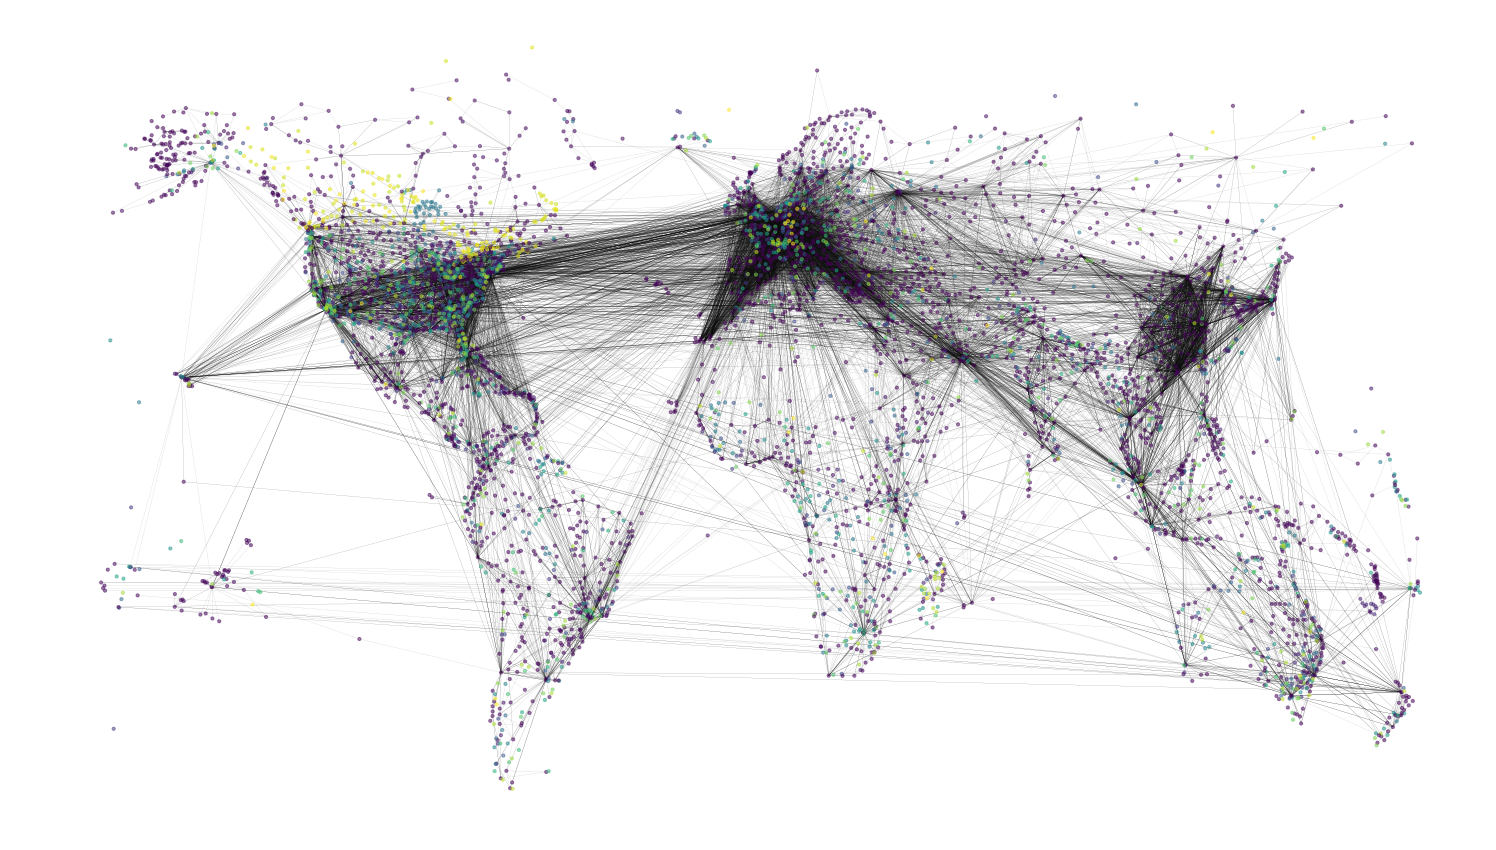

In [24]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph.to_undirected(), positions, 
                 width=0.1,alpha=0.5,node_size=10,with_labels=False, 
                 node_color = values, ax=fig.add_subplot(111))

plt.axis('off')
fig.savefig("output/airportgraph_communities.png", transparent=True, bbox_inches='tight')

### Communities by Continent

Now a custom community partition is considered, where each continent is its own community. What is expected here is that continents will tend to have a lot of flights internally on the same continent, but will have some hubs that connect the continents together.

**Preparing the data**

In [25]:
countriescontinents_df = pd.read_csv("data/CountriesContinents.csv")

In [26]:
countriescontinents_df.set_index(['Country','Continent']);

In [27]:
airports_continents = airports_df.merge(countriescontinents_df,on="Country",how="inner")

In [28]:
airports_continents_by_continent = airports_continents.groupby("Continent")
continents = list(airports_continents_by_continent.groups)


In [29]:
eur_df = list(airports_continents.loc[airports_continents['Continent'] == 'Europe'].groupby('IATA').groups);
oce_df = list(airports_continents.loc[airports_continents['Continent'] == 'Oceania'].groupby('IATA').groups);
afr_df = list(airports_continents.loc[airports_continents['Continent'] == 'Africa'].groupby('IATA').groups);
asia_df = list(airports_continents.loc[airports_continents['Continent'] == 'Asia'].groupby('IATA').groups);
na_df = list(airports_continents.loc[airports_continents['Continent'] == 'North America'].groupby('IATA').groups);
sa_df = list(airports_continents.loc[airports_continents['Continent'] == 'South America'].groupby('IATA').groups);

In [30]:
def calculateLC(graph,community_df):
    lc = 0
    for node in list(graph.nodes()):
        if node in community_df:
            lc += len([i for i in graph.neighbors(node) if i in community_df])
        
    return lc/2.0

def calculateKC(graph,community_df):
    return sum([graph.degree(node) for node in community_df])
    
def Mc(G,commmunity_df):
    return (calculateLC(G,commmunity_df)/len(G.edges()))-(calculateKC(G,commmunity_df)/(2*len(G.edges())))**2


**Calculating modularity**

In [31]:
#['Europe', 'Oceania', 'Africa', 'Asia', 'North America', 'South America']

modularity = Mc(airport_routes_digraph,eur_df) 
+ Mc(airport_routes_digraph,oce_df) 
+ Mc(airport_routes_digraph,afr_df) 
+ Mc(airport_routes_digraph,asia_df) 
+ Mc(airport_routes_digraph,na_df) 
+ Mc(airport_routes_digraph,sa_df)

0.008842948007765316

In [32]:
"The modularity for the continent partition: " + str(modularity)

'The modularity for the continent partition: -0.0066460778244896435'

**Discussing the outcome**

When dividing the different continents into different communities, a modularity that is almost as high as the best community partition modularity is achieved. Even though the modularity is not very high, i.e. sub-optimal, it is good that using continents as communities is close to the best possible community partition. 

It would make sense that partitioning by continent would create a sub-optimal community partition. Continents tend to have a fair amount of flights going within the continent, due to the physical size of the continents. This is also visible in the various plots. There are however still many intercontinental flights, which heavily lowers the modularity which is also why it is hard to find a good community partition. The different airports around the world are simply very well interconnected.

**Community by continent plot**

In [33]:
nodeColors = []
for node in airport_routes_digraph.nodes:
    continent = list(airports_continents.loc[airports_continents['IATA'] == node]['Continent'])[0]
    
    if continent == 'Asia':
        nodeColors.append('red')
    elif continent == 'Europe':
        nodeColors.append('blue')
    elif continent == 'Oceania':
        nodeColors.append('cyan')
    elif continent == 'Africa':
        nodeColors.append('pink')
    elif continent == 'North America':
        nodeColors.append('green')
    elif continent == 'South America':
        nodeColors.append('yellow')    
    else:
        nodeColors.append('brown')

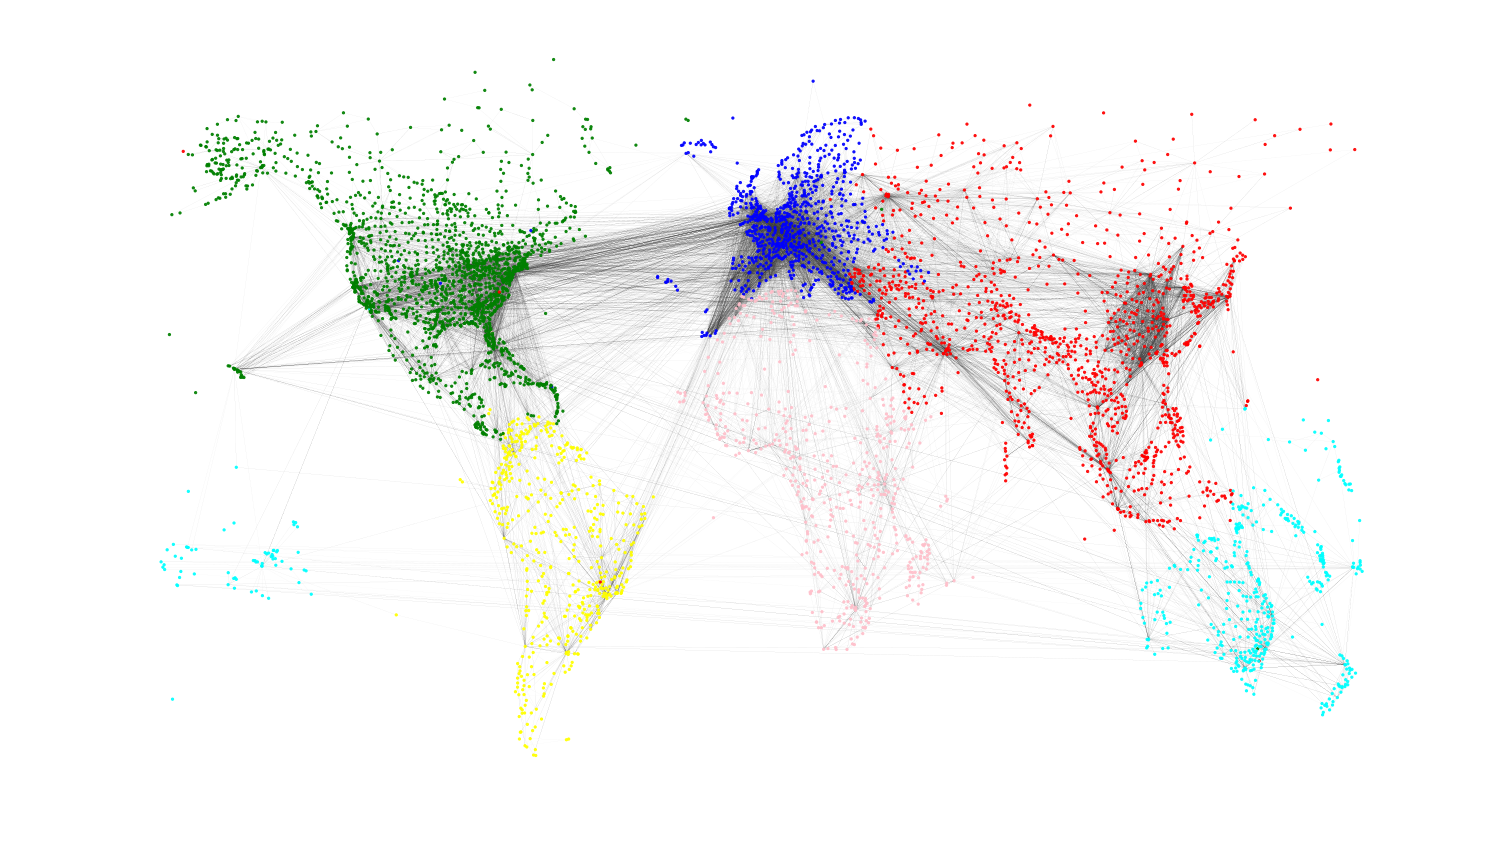

In [34]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.01,alpha=0.9,node_size=5,with_labels=False, 
                 node_color = nodeColors, ax=fig.add_subplot(111),arrowstyle='-')

plt.axis('off')
fig.savefig("output/airportgraph_continent_communities.png", transparent=True, bbox_inches='tight')

### Communities by Countries

**Calculating modularity**

In [35]:
countries = list(airports_df.groupby('Country').groups)

In [36]:
country_dfs = []

In [37]:
for country in countries:
    country_dfs.append((country,list(airports_df.loc[airports_df['Country'] == country].groupby('IATA').groups)))

In [38]:
country_by_modularity =  [(c[0],Mc(airport_routes_digraph,c[1])) for c in country_dfs]
country_com_modularity = sum([Mc(airport_routes_digraph,c[1]) for c in country_dfs])

In [39]:
"Modularity for the country community partition: " + str(country_com_modularity)

'Modularity for the country community partition: 0.0662300088373125'

**Finding the countries that contribute most to the modularity**

In [42]:
countries_sort_by_mod = sorted(country_by_modularity, key=lambda x: x[1], reverse=True)
top_10_country_mod = countries_sort_by_mod[:10]
bot_10_country_mod = countries_sort_by_mod[-10:]

print("Top 10:")
print(top_10_country_mod)
print(" ")
print("Bottom 10:")
print(bot_10_country_mod)

Top 10:
[('Canada', 0.00541545549852876), ('China', 0.005297605989823855), ('Brazil', 0.004866700712185934), ('Russia', 0.004384176747079754), ('Australia', 0.0030592973693479328), ('United States', 0.0024651930707599787), ('Japan', 0.002260962270482145), ('India', 0.002169604402962817), ('Mexico', 0.0021663029137962823), ('Indonesia', 0.0020758918718106274)]
 
Bottom 10:
[('Serbia', -2.549973963139777e-06), ('Malta', -2.8995851819130576e-06), ('Kuwait', -3.0828103275316227e-06), ('Cyprus', -5.189240830943308e-06), ('Hong Kong', -2.822572199481447e-05), ('Belgium', -3.0756508579466526e-05), ('Singapore', -3.7764426512262384e-05), ('Netherlands', -4.273372843755539e-05), ('United Arab Emirates', -5.214356250247382e-05), ('Germany', -0.0001508894298759241)]


**Discussing the outcome**

The modularity when creating communities based on countries is very low. This makes sense, since most countries are not very big and do not have a lot of domestic flights. Therefore many of outgoing flights from those countries are international. The bigger countries should be more ideal as a community, since their vast area would imply more domestic flights, but there aren't that many very large countries and  they too have large international airports connecting the country to other contintents. This is also exactly what can be noted by looking at the top 10 and bottom 10 countries by their contribution to the modularity of the whole community. The bottom 10 are smaller countries, and in many cases small islands, which further proves the above statement.

**Country partition community plot**

In [43]:
countrylabels = []
for node in airport_routes_digraph.nodes():
    countrylabels.append(countries.index(list(airports_df.loc[airports_df['IATA'] == node]['Country'])[0]))

In [44]:
colors = list(map(plt.cm.get_cmap('hsv', len(set(countries))+1),countrylabels))

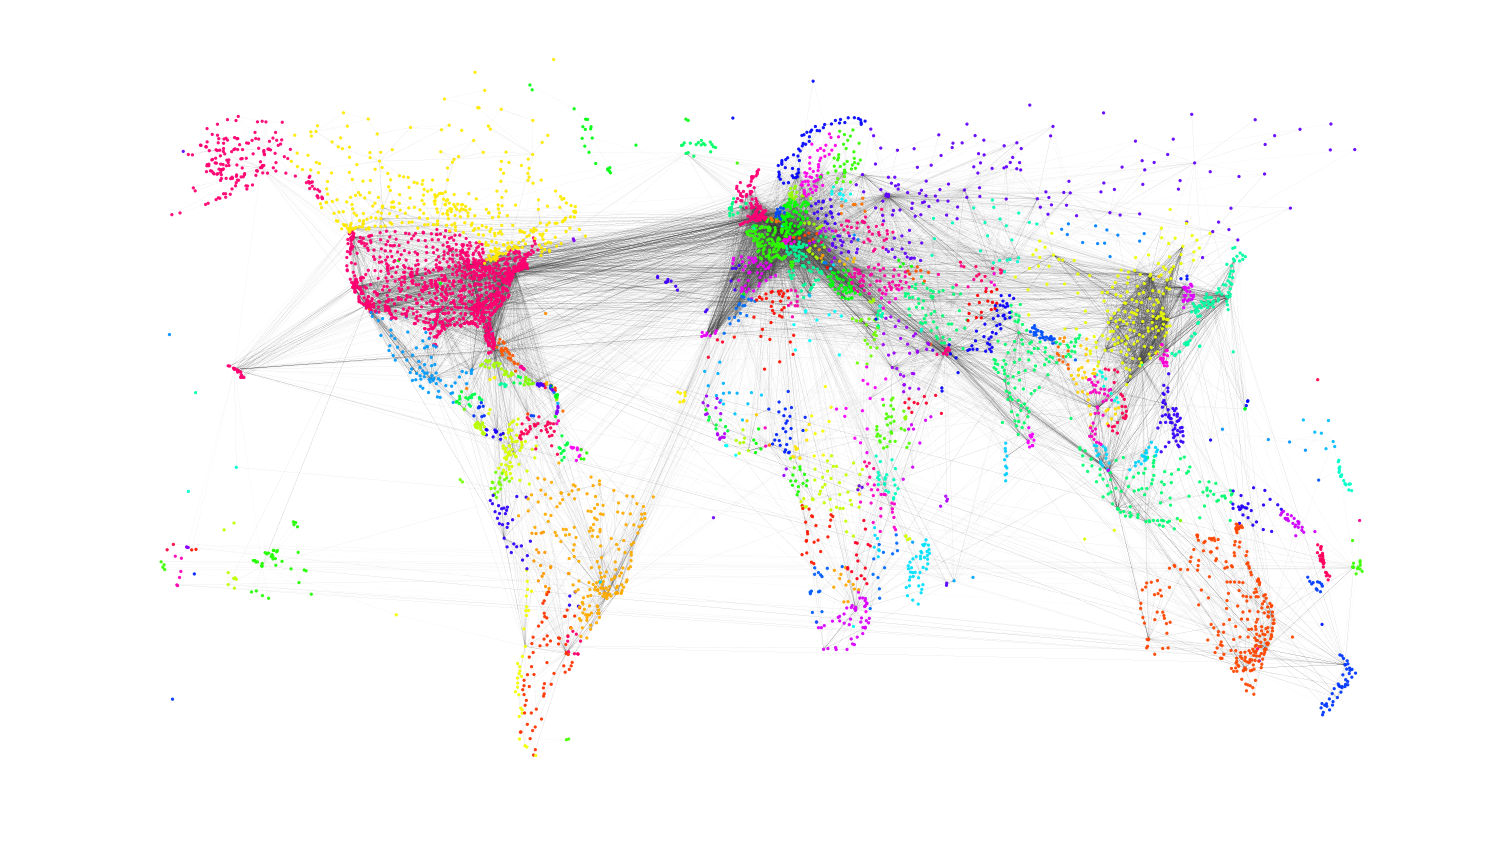

In [45]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.01,alpha=0.9,node_size=5,with_labels=False, 
                 node_color = colors, ax=fig.add_subplot(111),arrowstyle='-')

plt.axis('off')
fig.savefig("output/airportgraph_country_communities.png", transparent=True, bbox_inches='tight')

### Further Community Analysis

It was chosen also to analyze, whether hub airports tend to connect communities together. Here we're keeping the community partition using continents in mind, since it makes more sense to analyze that partition, than the best partition which at a quick glance is nonsensical.

**Plotting the location of the top 10 hubs**

In [46]:
#The following hubs are found based on degree.
hubs = ['Hartsfield Jackson Atlanta International Airport',"Chicago O'Hare International Airport",
        'Beijing Capital International Airport','Charles de Gaulle International Airport',
        'London Heathrow Airport','Los Angeles International Airport',
        'Frankfurt am Main International Airport','Amsterdam Airport Schiphol',
        'Dallas Fort Worth International Airport','John F Kennedy International Airport']

In [47]:
nodesizes = []
nodeColors = []
edgeColors = []

#Hubs are colored red and a given a larger size than the remaining airports.
for node in airport_routes_digraph.nodes:
    continent = list(airports_continents.loc[airports_continents['IATA'] == node]['Continent'])[0]
    if (list(airports_df.loc[airports_df['IATA'] == node]['Name'])[0] in hubs):
            nodeColors.append('red')
            nodesizes.append(100)
    else:        
        nodesizes.append(2)
        
        if continent == 'Asia':
            nodeColors.append('purple')
        elif continent == 'Europe':
            nodeColors.append('blue')
        elif continent == 'Oceania':
            nodeColors.append('cyan')
        elif continent == 'Africa':
            nodeColors.append('pink')
        elif continent == 'North America':
            nodeColors.append('green')
        elif continent == 'South America':
            nodeColors.append('yellow')    
        else:
            nodeColors.append('brown')
            
#Edges going in or out of hubs are colored red aswell.
for edge in airport_routes_digraph.edges:
    if (list(airports_df.loc[airports_df['IATA'] == edge[0]]['Name'])[0] in hubs or list(airports_df.loc[airports_df['IATA'] == edge[1]]['Name'])[0] in hubs):
        edgeColors.append('black')
    else:
        edgeColors.append('white')

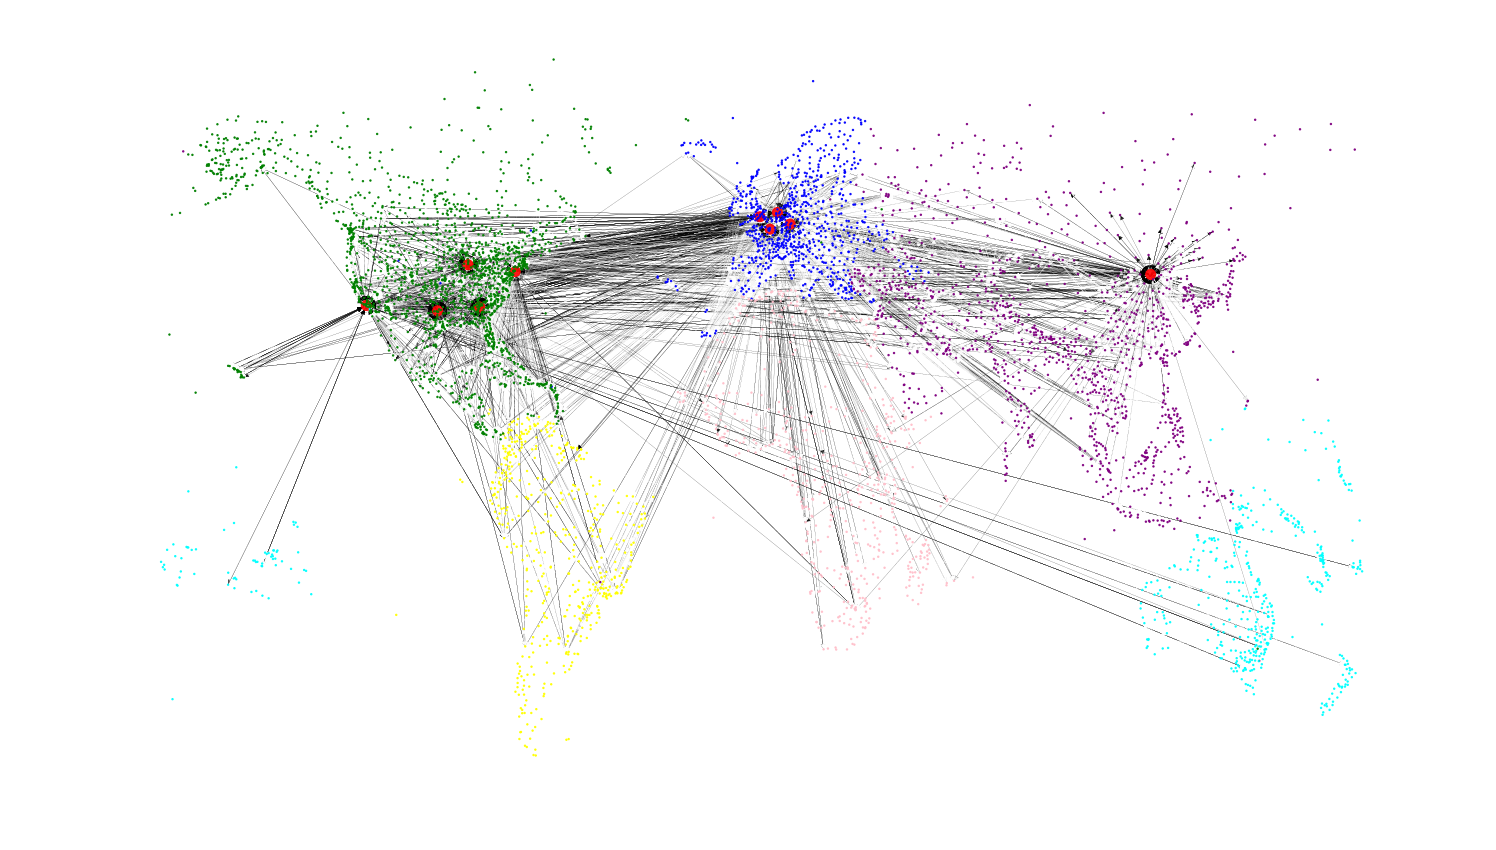

In [48]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.9,node_color=nodeColors,node_size=nodesizes,edge_color=edgeColors,with_labels=False, 
                 ax=fig.add_subplot(111))

plt.axis('off')
fig.savefig("output/airportgraph_with_high_degree_hubs.png", transparent=True, bbox_inches='tight')

**Analysing the plot**

Considering the plot above, the red plots are the hubs that were defined. The only edges that can be seen are flights originating from or arriving at one of the top 10 hub airports based on degree. What could be considered is whether or not the hubs tend to be links between communities and therefore heavily reduce the modularity. This is the case, as it can be seen that many of the flights from or top hubs are intercontinental. This is expected, since the hubs in general are major international airports that have flights between many different continents. It could be the case that the hub only connects with other nodes in the same community, but this would be most likely be a regional airport and the major hubs are definetely not regional airports. It is therefore clear that hubs tend to make it harder to find a good community partition, since they ensure that the different parts of the world generally are very well connected.

### Overall Outcome of Community Detection

To summarize the outcome of this section, it was found out that optimal partition for communities has no sensical structure in terms of countries or continents, but it does however make sense how such a partition can be good, due to how well different parts of the world are connected through larger airports.

By partioning the graph by contient, the modularity was almost as high as the best community partition, which made this partition be the focus of the analysis. It was further solified that continents were the best partition to consider, even though the modularity wasn't very good, since that larger countries that make up the majority of contients (e.g. USA, China, Canada, Brazil, ...) were contributing a lot to the modularity of the partitioning by countries.

Overall, it was concluded that there tends to be a lot of flights internally within larger continents, and then there are fewer but still quite many flights occuring between continents. Here the hubs play a large factor in connecting the different contients. 

# Shortest Paths
Next, it would be interesting to look into how long the distances across the graph really is. It is therefore very relevant to look into the [shortest paths](http://networksciencebook.com/chapter/2#paths) of the network, to get an estimate of these distances.

In order to find the shortest paths, the graph had to be weakly connected, i.e. removing subraphs which are completly unconnected with the rest of the graph, keeping the largest connected subgraph. Since the original graph was not weakly connected, the NetworkX function *average_shortest_path_length* could not run, as this requires that a directed graph is weakly connected (Completly connected for undirected graphs).

In [49]:
airport_nodes_weakly = [n for n in airport_nodes if n in airport_src or n in airport_dest]

airport_routes_digraph_weakly = nx.MultiDiGraph()

airport_routes_digraph_weakly.add_nodes_from(airport_nodes_weakly)
airport_routes_digraph_weakly.add_edges_from(edges);

Here the largest connected sub graph is found using the function *connected_component_subgraphs* function of NetworkX. To get a sense of the size differences between the largest subgraph and the full, unconnected graph, the size of the two graph are printed.

In [53]:
airport_undirected = nx.to_undirected(airport_routes_digraph_weakly)
nx.is_connected(airport_undirected)

subgraphs = nx.connected_component_subgraphs(airport_undirected) # Find connected component subgraphs

print('Edges in graph:' + str(airport_undirected.number_of_edges()))
print('Nodes in graph:' + str(airport_undirected.number_of_nodes()))
big_subgraph = max(subgraphs, key=lambda x: x.number_of_edges()) # Find the largest subgraph

print()
print('Edges in subgraph: ' + str(big_subgraph.number_of_edges()))
print('Nodes in subgraph: ' +  str(big_subgraph.number_of_nodes()))

Edges in graph:66068
Nodes in graph:3186

Edges in subgraph: 33913
Nodes in subgraph: 3154


As it is observed the largest sub graph is not much smaller than the original, unconnected graph. Keep in mind the reason that there are far fewer edges it because the sub graph is undirected without duplicate edges. When the undirected version of the original, directed, graph, *airport_undirected*, is made it does not remove the duplicate edges, which are a result of converting a directed graph to undirected.

## Average shortest path 
Firstly it would be interesting to get an understanding of what the average number of flights are to get from any node *a* to any other node *b*. To find this path length, the average shortest path length of the network will be calculated.

With the new largest sub graph, the average shortest path is found using *average_shortest_path_length* of NetworkX is used on the large sub graph.

In [58]:
print('The average shortest path through out our network is: ' 
      + str(nx.average_shortest_path_length(big_subgraph)))

The average shortest path through out our network is: 3.9608958142148443


With the average shortest path of 4, it indicates how few flights are required to travel to the other side of the planet. It also shows that most trips requires a few extra flights to reach an international airport, when flying between smaller airports.

## Longest Shortest Path

Next step in the world of shortest paths is to look into what nodes in the airport network is furthest from eachother, or in other words, what is the longest path of all the shortest paths throughout the network.

The first step in finding the longest shortest path is done here with the use of the function *shortest_path_length* of NetworkX. This function returns a list of tuples. These tuples contains firstly a source-node, and secondly a dictionary, containing target-nodes as keys and the length of the shortest path from the source-node to the target-node. 

The Python list comprehension shown in the code cell below makes a list of tuples only containing target-node which is the furthest away from any given source-node. Only the ten longest shortest paths are saved.

In [55]:
shortest_path_lengths = sorted([
    (k, max(zip(v.values(), v.keys()))) 
    for k,v in nx.shortest_path_length(big_subgraph)],
    key=lambda x: x[1][0], reverse=True)[:10]

In order to actually see the longest shortest paths, the next code cell fetches the 10 actual shortest paths, using the *shortest_path* function of NetworkX.

In [56]:
paths = []
for item in shortest_path_lengths:
    paths.append(nx.shortest_path(big_subgraph,source=item[0],target=item[1][1]))

The first element of this list of shortest paths will thus be the longest throughout the aviation network, which in the following is printed:

In [59]:
print(paths[0])
for p in paths[0]:
    print(airports_by_iata_df.get_group(p).iloc[0]['Name'])

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(paths[0])? (<ipython-input-59-1cd9d5da8a32>, line 1)

In [ ]:
print('The longest shortest path has length: ' + str(len(paths[0])))

A trip that requires one to fly from the outskirts of Australia to the outskirts of Canada, a flight between quite alot of smaller airports. Especially in Canada, where the trip requires one to fly in between lots of small airports, with very short trips in between, results in a trip with alot of connecting flights. In fact; once the airplane has landed at Lester B. Pearson International Airport the rest of the trip takes place in Canada, which is more than half of the airports included in the shortest path!

The next code cell finds the paths used in this shortest path, so that it can be visualized

In [ ]:
longest_path_edges = []
for i in range(0,len(paths[0])-1):
    longest_path_edges.append((paths[0][i],paths[0][i+1]))

In [ ]:

options = {
    'width': 0.2,
    'alpha': 0.9,
    'node_size': 50,
    'with_labels': False
}

The following plot shows the original plot of the aviation graph, but the longest shortest path is colored red, so that one can try to see how the trip traverses the globe.

In [ ]:
fig = plt.figure(figsize=(26,15))
nx.draw_networkx(airport_undirected, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))
nx.draw_networkx_edges(airport_undirected,positions, edgelist=longest_path_edges, width = 4, alpha = 1, edge_color='r')
plt.axis('off')
fig.show()

In [ ]:
fig.savefig("output/longest_shortest_path.png",transparent=True, bbox_inches='tight')

Here the longest shortest path can be seen and when looking at it one truely understands the length of this route. But the as the length of the shortest longest path is based on the number of edges, one needs to take this result with a grain of salt. Since the edges does not measure how long the trip lasts it is not necessarily the case the the longest shortest path is viable if one looks at for how long the trip lasts, especially since most of the airports visited in the longest shortest path is very close by eachother.

# Centrality measures
To get an understanding of how well connected the different nodes, airports, are, it would be interesting to look at some different centrality measures. In this project, three different centrality measures are looked at.

## Degree centrality
The first centrality measure which are looked at is the degree centrality, which is the most simple centrality measure. This measure is simply the sum of number of incoming edges and number of outgoing edges.

The reason that the degree centrality is relevant for the airport network, is because it explains how many different routes goes through the airports, and thus gives an estimate of how much which the airport handles.

To visualize the node degrees, the aviation graph is plotted with the node sizes depending on the node degrees.

In [ ]:
d = dict(nx.degree(big_subgraph))

In [ ]:
fig_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 1 for v in d.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_degree.show()

With many flight routes across the Atlantic, it is not very surprising that lots of the airports in Europe and the Americas have rather high degrees. With so many airports in Europe, it is hard to detect specific airports with high degree. On the west coast of the US, it is possible to detect LAX (Los Angeles International Airport), a very large airport which have many international flights to Europe and national flights around the US.

In [ ]:
fig_degree.savefig("output/graph_degree_size.png",transparent=True, bbox_inches='tight')

### Specific airports with the highest degree centrality measure
To get a view of the airports with the highest degrees, ie get an understanding of which airports are most connected, the top 10 airports in terms of degree is listed below.

In [ ]:
top_airports_degree = sorted(d.iteritems(), key = lambda (k,v):(v,k), reverse=True)[:10]
for ai,de in top_airports_degree:
    print('Airport: ' + airports_by_iata_df.get_group(ai).iloc[0]['Name'] + 
          '\n Degree: ' + str(de))

By far the airport with the highest degree is Hartsfield Jackson Atlanta International Airport, an international airport used heavily for especially connecting airports in the southern US to the rest of the world. Other interesting airports are London Heathrow Airport and Charles de Gaulle International Airport which are two very large airports in Europe connecting the continent to the rest of the world and Beijing Capital International Airport a very central airport in Asia.

## Betweenness centrality
The next step is to look into which airports are most often used for connecting flights. One can find an estimate of this using the betweennes centrality, which goes as follows:

$$ g(v) = \sum_{s\neq v\neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$$ 

Where $\sigma_{st}$ is the number of shortest paths from a node $s$ to a node $t$ and $sigma_{st}(v)$ is the number of the shortest between node $s$ and node $t$ which goes through node $v$. So essentially the betweenness centrality is a measure of how many shortest paths that goes through a specific node.

First let the betweenness centrality be measured, so below is the airport network plotted using the betweenness centrality as the node sizes.

In [ ]:
bc = nx.betweenness_centrality(big_subgraph)
fig_betweeness = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 7000 for v in bc.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_betweeness.show()

Here we see the graph, plotting the nodes' sizes in terms of there betweenness centrality. Here LAX is visible again, more clearly, and it also shows lots of the european airports have high betweeness centrality. Interestingly, one airport in Alaska have a rather high betweenness centrality, which one would think is because this airport connects the rest of the smaller Alaskan airports to the rest of the world. There are also a few airports over in the east (China, Japan and Australia) which stand alone with a rather high betweenness centrality. This indicates that these airports connects there respective areas to the rest of the world.

In [ ]:
fig_betweeness.savefig("output/graph_betweeness_centrality.png",transparent=True, bbox_inches='tight')

### Specific airports with the highest betweeness centrality

To get a better understanding of which airports are most relevant in shortest paths, the 10 airports with highest betweenness centralities are listed.

In [ ]:
top_airports_betweenness = sorted(bc.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, be in top_airports_betweenness:
    print('Airport: ' + str(airports_by_iata_df.get_group(ai).iloc[0]['Name']) + 
          '\n Betweenness: ' + str(be))

Besides the more famous and busy international airports, which also was present in the airports with highest degree, one can also see the outlier of Ted Stevens Anchorage International Airport. This airport, as mentioned before is placed in Alaska, and has the task of connecting many of the Alaskan airports to the rest of the world, resulting in this airport having a large betweenness centrality.

## Eigenvector centrality
Lastly it would be interesting to get an understanding of how well connected the different nodes are beyond the degree. To get a look at this, the eigenvector centrality is looked at. What this centrality measure does is it scores nodes not just by how many neighbors they have, but also based on what scores the neighbors have gotten. A well connected community of nodes will individually recieve even higher scores.

To visualize the nodes' eigenvector centrality measures, the next plot have the node sizes depend on the eigenvector centrality measure.

In [ ]:
ec = nx.eigenvector_centrality(nx.Graph(big_subgraph))
fig_eigen = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=d.keys(),
                 node_size=[v * 3000 for v in ec.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 0.5,
                )
plt.axis('off')
fig_eigen.show()

The eigenvector centralities lightens up the world, making the nodes brighten up. This indicates that the world's airports are very connected, easily giving lots of the different airports high scores in terms of eigenvector centrality. Notably, some airports throughout Africa and Oceania are closely connected, giving them higher eigenvector centralities.

In [ ]:
fig_eigen.savefig("output/graph_eigenvector_centrality.png",transparent=True, bbox_inches='tight')

### Specific airports with the highest eigenvector centralities
To get an understanding of how closely connected the larger airports are connected, the top 10 airports in terms of egenvector centralities are listed.

In [ ]:
top_airports_eigenvector = sorted(ec.iteritems(),key=lambda(k,v):(v,k),reverse=True)[:10]
for ai, ee in top_airports_eigenvector:
    print('Airport: ' + str(airports_by_iata_df.get_group(ai).iloc[0]['Name']) + 
          '\n Eigenvector: ' +  str(ee))

This shows that the airports with highest eigenvector centralities are all placed in Europe, where all airports are closely connected, greatly increasing all of their eigenvector centralities, as they all effect eachother.

## Tweets sentiment

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import string
import pickle
from wordcloud import WordCloud
from PIL import Image
import os
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm_notebook as tqdm
import math
import imageio

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-deep')

from typing import List

data_path = 'data'

Retreive the airport data from https://openflights.org/data.html.

In [ ]:
airports_filename = 'airports.csv'
routes_filename = 'routes.csv'

In [ ]:
airports = pd.read_csv(os.path.join(data_path, 'airports.csv'))
airports.set_index('Airport Id', inplace=True)

## TF-IDF analysis of tweets from the airports

### Theory of Term Frequency - Inverse Document Frequency (TF-IDF)

TF-IDF is a measure to determine how important each individual word in a document is in relation to a collection of documents.
The idea behind the measure, is that the TF-IDF value for a word increases with the number of occurences in that document, which is the term frequenty (TF).
This is calculated by counting the number of times the word occures in the document and divide it by the total number of words in the document, as shown below, where $f_t$ is the number of times the term $t$ appears in the document $d$.

$$ tf(t, d) = \frac{f_t}{\sum_{t \in d} f_t}  $$

The IDF measure reflects the fraction of documents in which the word appears in, i.e. the more documents a word appear in, the higher its IDF score is.
This is calculated by first finding the number of documents the term $t$ appears in, denoted $n_t$.
The inverse fraction of the number of documents it appears in is then calculated.

$$ idf(t, D) = \lg{\frac{|D|}{n_t}} $$

IDF is scaled logarithmically to produce more significate differences between the most and least common terms.
From this formular, it is clear that when the term $t$ occures in few documents ($n_t$ is close to zero), the IDF score is high, while if it occures in every document ($n_t = |D|$), then the IDF score is zero.
The IDF score can therefore capture that if a word appears in every document, it will properly not say anything very specific to that document.

The combined TF-IDF score is then calculated by multiplying these two scores with eachother.

$$ tfidf(t, d, D) = tf(t, d) \cdot idf(t, D) $$

Analysing this combined measure, a word that appears frequently in a single document, but not anywhere else, will get a high TF-IDF score, as it is important to that document.
A word that appears many times in a document, but is also used in every other document gets a lower score, is it does not tell you anything specific about the single document.

### Data 

The tweets have been retreived from twitter's API. The data we have collected can be found [here](https://1drv.ms/u/s!AoyV20xD2_Tx0vIuF0HGgFg-5CyaIw).
Every file coresponds to the id of an airport, and contain up to 100 of the latest tweets from the given airport (the dataset was generated on 2018-11-08).
As tweets can be multiline, each tweet is seperated by ';;;' in the files.
(The newlines could have been removed for a simpler format when extracting the data, but was it chosen to keep these to have the unprocessed data)

In [ ]:
tweets = {
    row['Name']: ''.join(open(
        os.path.join(data_path, 'tweets', str(index)), 'r', encoding='utf-8'
    ).readlines())
    for index, row in airports.iterrows()
}

Each tweet is tokenized and cleaned to remove stopwords, punctuation, and blacklisted words, such as keywords used by twitter.

In [ ]:
blacklisted_tokens = [
    'rt',
    'amp'
]
def tokenize(text: str, names: set = []) -> List[str]:
    sw = stopwords.words('english')
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens
                  if token not in names
                  and token not in sw
                  and not token.isdigit()
                  and token not in blacklisted_tokens
         ]
    return tokens

In [ ]:
%%capture cap --no-stderr
tokens = { airport: tokenize(document) for airport, document in tqdm(tweets.items()) }

Calculating how often each term occures in the documents are done with the function below. 
This is done by going through each of the tokens and add then checking of the word is in the document or not.
If it is, one is added to the term freqency.
In the end, this gives exactly the number of documents the term occures in.

In [ ]:
def calculate_n_ts(tokens: list, documents: list) -> set:
    ''' Calculate the n_ts for a list of tokens given a list of documents
    '''
    return {
        word: sum(1 for document in documents if word in document)
           for word in set(tokens)
    }

As calculating how many documents each word occure in takes some time, we have cheated a little and saved the result. 
To optimize the calculations, we have transformed each of the documents into sets for faster look-up times. As the computation can take some time, the word document frequency has been stored on disk.
You can uncomment the block below to recompute it yourself.

In [ ]:
# tokens_set = { airport: set(document) for airport, document in tokens.items() }
# n_ts = { 
#     airport: calculate_n_ts(ts, tokens_set.values()) 
#     for airport, ts in tqdm(tokens.items())
# }
# with open(os.path.join(data_path, 'n_ts.data'), 'wb') as f:
#     pickle.dumb(f)

In [ ]:
with open(os.path.join(data_path, 'n_ts.data'), 'rb') as f:
    n_ts = pickle.load(f)

Calculating the inverse document frequency (IDF) can now be done using the following function, where foreach term the ratio between the total number of documents and the number of documents the term occure in is computed.
To get a more significat distribution, $log_2$ is applied to each inverse document frequency.

In [ ]:
def calculateIDF(nts: set, N: int, base=2) -> set:
    return { word: math.log(N / n_t, base)
        for word, n_t in nts.items()
    }

Then the IDF is calculated for the tweets at each airport.

In [ ]:
N = len(list(airports['Name']))
IDF = {
    airport: calculateIDF(n_ts[airport], N)
    for airport in list(airports['Name'])
}

Calculate the combined term frequency-inverse document frequency (TF-IDF), the term frequency for each word is multiplied with the IDF of the given term.

In [ ]:
def calculateTF_IDF(tfs: set, IDFs: set) -> set:
    return {
        term: tf * IDFs[term]
        for term, tf in tfs.items()
    }

For each airport, the term freqency is calculated for all of the terms for the given tweets.

In [ ]:
freq = { airport: FreqDist(ts) for airport, ts in tokens.items() }

Again, the function above is simply applied for each airport, using the frequencies of the terms from above.

In [ ]:
TF_IDF = {
    airport: calculateTF_IDF(freq[airport], IDF[airport])
    for airport in tokens.keys()
}

For later use, we also compute the combined list of tokens for all the airports, along with the frequency of these.

In [ ]:
all_tokens = [t for ts in tokens.values() for t in ts]

In [ ]:
freqency_total = FreqDist(all_tokens)

In [ ]:
TF_IDF_sorted = {
    airport: sorted(words.items(), key=lambda x: x[1], reverse=True)
    for airport, words in TF_IDF.items()
}

Now we can have a look at which words are used at the busiest airports in the world.

In [ ]:
busiest_airports = [
    'Hartsfield Jackson Atlanta International Airport',
    'Beijing Capital International Airport',
    'Dubai International Airport',
    'Los Angeles International Airport',
    'Tokyo Haneda International Airport',
    "Chicago O'Hare International Airport",
    'London Heathrow Airport',
    'Chek Lap Kok International Airport', # Hong Kong
    'Shanghai Pudong International Airport',
    'Indira Gandhi International Airport'
]

In [ ]:
for airport in busiest_airports:
    print(f'{airport}'.ljust(50), f'{[x[0] for x in TF_IDF_sorted[airport][:5]]}')

For the two busiest airports in the world, we see that the world *office* is often used, pointing towards that many people how travel though these airports also works while they are at the airport.
Other than this, a few refrences to specific Twitter accounts can be seen.
Other

## Word clouds

We here define a helper function to draw wordclouds for the remaining part of the notebook.

In [ ]:
def drawWordCloud(text: str, title: str, mask: str = None):
    if mask:
        mask = np.array(Image.open(os.path.join('masks', mask)))
        
    wordcloud = WordCloud(
        collocations=False,
        mask=mask,
        background_color='white',
        contour_width=3, 
        contour_color='steelblue'
        ).generate(text)
    fig, ax = plt.subplots(figsize=(16, 8))
#     ax.set_title(title)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    imageio.imwrite(f'output/{title}.png', np.array(wordcloud))
    plt.show()

First we can combine the tokens from the tweets from every airport, to get an overview of which words are used the most at airports.

In [ ]:
combined_all_tokens = ' '.join(all_tokens)

In [ ]:
drawWordCloud(combined_all_tokens, 'Overall sentiment', 'Airplane_silhouette.png')

To no suprise, the word *airport* seems to be the most used word at airports.
Another word that are weighted highly is *office*. 
When having a look at some of the tweets, it quickly becomes clear that many people are tweeting about them working at their "airport office", which is why it appears so frequent. 
Words like *bar* and *resturant* also appears frequently, pointing towards many people eating at stocking up before heading on a flight with poor food. 

Another expected word that appear is *cancelled*, which are from people tweeting about their cancelled flights. 
This word would be expected to be very prominent among the negative tweets, which we will look at later.

## Sentiment

To calculate the sentiment of each of the airports, we are using the data set created in [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752).
This data set contains over 10,000 individual words and their happiness score, which is generated by having many unique people rate each of the words and calculating a aggregated score based on this.

In [ ]:
happiness = pd.read_csv(os.path.join(data_path, 'sentiment.csv'), delimiter='\t')

We will be using the average happiness score for each of the words to calculate the sentiment for each of the airports.
First we map every word in the happiness data set to only store the average happiness for each word.

In [ ]:
h_avg = { happiness['word'].iloc[i]: happiness['happiness_average'].iloc[i] 
         for i in range(len(happiness.word)) 
    }

To calculate the sentiment of a list of tokens, all the tokens that are not in the happiness data set are first filtered away, as we cannot tell if these words are happy or sad.
Next, the overall happiness score of the tokens is to multiply the score of each token with the frequency of the token, and take the average over all of the tokens. 

In [ ]:
def calculate_sentiment(tokens: list, h_avg: dict) -> int:
    tokens = [word for word in tokens if word in h_avg]
    if len(tokens) == 0: 
        return 0
    frequency = FreqDist(tokens)
    return sum(h_avg[word] * frequency[word] for word in tokens) / len(tokens)

This time we need a list of tweets for each of the airports, which is found by splitting the tweets data set that we have prepared earlier.

In [ ]:
tweets_list = { airport: tws.split(';;;')
          for airport, tws in tweets.items()
     }

These tweets are again tokenized, this time each one by themself.

In [ ]:
tweets_tokenized = { 
    airport: [tokenize(tweet) for tweet in ts]
    for airport, ts in tweets_list.items()
}

Using the tokenized tweets, the sentiment for each tweet is then calculated, for each of the individual airports. 

In [ ]:
sentiment = {
    airport: [calculate_sentiment(tweet, h_avg) for tweet in ts]
    for airport, ts in tweets_tokenized.items()
}

Like before, we also combine all of the tweets from each of the airports to one large list, 
along with a list of all the sentmient scores. 
The overall distribution of the tweets sentiment can thereby be plotted. 

In [ ]:
tweets_all = [tweet for ts in tweets.values() for tweet in ts]

In [ ]:
sentiment_all = [score for ss in sentiment.values() for score in ss]

Helper function to plot the distribution of the sentiment in all of the tweets.

In [ ]:
def plotDistribution(data: list, title: str):
    sorted_data = [x for x in sorted(data) if x < 10 and x != 0]
    fig, ax = plt.subplots(1, figsize=(16,8))
    ax.hist(sorted_data, bins=30)
    ax.set_title(title)
    ax.set_xlabel('Happiness score')
    ax.set_ylabel('Frequency')
    fig.show()

In [ ]:
plotDistribution(sentiment_all, 'Overall sentiment of tweets')

The distribution somewhat follows a normal distribution, however with the center of the distribution being a bit lower and spread out.
It is clear that the overall sentiment of the tweets are slighly more positive than negative, as the happiness score goes from one to ten, and only a few tweets have sentiments less than half (five).

In [ ]:
mean_sentiment_all = np.mean(sentiment_all)
std_sentiment_all = np.std(sentiment_all)
print('Sentiment mean and standard deviation of all the tweets. Mean: {0:f} sigma: {1:f}'
      .format(mean_sentiment_all, std_sentiment_all))

We can repeat this to find the distribution of the sentiment for each of the airports.

In [ ]:
sentiment_airports = { airport: np.mean(scores) for airport, scores in sentiment.items() }

In [ ]:
plotDistribution(sentiment_airports.values(), 
                 'Distribution of the sentiment from each airport')

In [ ]:
mean_sentiment_airports = np.mean(list(sentiment_airports.values()))
std_sentiment_airports = np.std(list(sentiment_airports.values()))
print('Sentiment mean and standard deviation of the airports. Mean: {0:f} sigma: {1:f}'
      .format(mean_sentiment_airports, std_sentiment_airports))

This distribution more clearly follows a normal distribution.
The distribution is quite shallow, with a standard deviation of 0.2.
This means that the sentiment of people on Twitter does not vary a lot between airports.

### Negative tweets

The negative tweets is found by taking all the tweets that lie below one standard deviations from the mean.
These are found for each airport below.

In [ ]:
negative_tweets = {
    airport: [t for i, t in enumerate(ts) 
              if sentiment[airport][i] <= mean_sentiment_all - std_sentiment_all]
    for airport, ts in tweets_tokenized.items()
}

In [ ]:
drawWordCloud(' '.join([' '.join(t) for ts in negative_tweets.values() for t in ts]), 
      'Negative tweets', 'Airplane_silhouette.png')

Here we see words like *die*, which must be assosiated with people being afraid of flying.
We also see words like *arrested* and *custody* as frequent among the negative tweets, which, with no suprise, points towards people being stopped by the airport security does not enjoy their time there.
Other negative words we would expected to see at an airport also appear, such as *cancelled*, *delay*, and *queues*.

When looking at some of the smaller words used in the negative tweets, we see that they are a lot of account names are used, such official airport accounts.
This points towards most of the negitive tweets being directed towards organisations that control the airports.

### Positive tweets

Positive tweets can be found in a similar way, by taking all the tweets lying above standard deviations from the mean.

In [ ]:
positive_tweets = {
    airport: [t for i, t in enumerate(ts) 
              if sentiment[airport][i] <= mean_sentiment_all + std_sentiment_all]
    for airport, ts in tweets_tokenized.items()
}

In [ ]:
drawWordCloud(' '.join([' '.join(t) for ts in positive_tweets.values() for t in ts]), 
      'Positive tweets', 'Airplane_silhouette.png')

For the positive tweets, we see words such as *office*, which would point to many people are enjoying working from the airport.
Words like *bar*, *resturant*, and *nightclub* are also found, poniting to that most people enjoy being at these places.
There is also a lot of words related to everday live, such as *home*, *daycare* and *preschool*, which could be because people are looking forward to get home, perhaps to their children.

## The least and most liked airports in the world

We start by sorting the airports by their sentiment score, which will enable us to find the most and least liked airports in the world.

In [ ]:
sorted_sentiment = sorted(sentiment_airports.items(), key=lambda x: x[1])

In [ ]:
def showAirportScore(airport: str):
    print(f'{airport}'.ljust(50), f'{sentiment_airports[airport]}')

Now we can find the top five least and most liked airports in the world.

In [ ]:
print('The least liked airports in the world')
for airport, _ in sorted_sentiment[:5]:
    showAirportScore(airport)

What the four least liked airports have in common, is that they are all located on small islands, being quite small airports as well.

In [ ]:
print('The most liked airports in the world')
for airport, _ in sorted_sentiment[::-1][:5]:
    showAirportScore(airport)

For the most liked airports, we see that most of these are placed in the middle east. 

Now we also want to have a look at the busiest airports in the word.
A list of these have been extracted from Wikipedia and can be seen below.

In [ ]:
busiest_airports = [
    'Hartsfield Jackson Atlanta International Airport',
    'Beijing Capital International Airport',
    'Dubai International Airport',
    'Los Angeles International Airport',
    'Tokyo Haneda International Airport',
    "Chicago O'Hare International Airport",
    'London Heathrow Airport',
    'Chek Lap Kok International Airport', # Hong Kong
    'Shanghai Pudong International Airport',
    'Indira Gandhi International Airport'
]

In [ ]:
for airport in busiest_airports:
    showAirportScore(airport)

In the output above, it can be seen that most of the busiest airports in the world is close to the average of all of the airports in the world, however all of them is slightly below.
London Heathrow Airport and Tokyo Haneda International Airport are quite low on the list, while Dubai International Airport is most more liked than all of the other busy airports.

## Sentiment of hubs

It was found earlier that hubs generally make it harder to generate good community partitions with low modularity. Sentiment of hubs can then be considered. This overlaps with the previous section, since some of the hubs are also considered some of the busiest airports, but not all of them.

In [ ]:
hubs = ['Hartsfield Jackson Atlanta International Airport',
        "Chicago O'Hare International Airport",
        'Beijing Capital International Airport',
        'Charles de Gaulle International Airport',
        'London Heathrow Airport',
        'Los Angeles International Airport',
        'Frankfurt am Main International Airport',
        'Amsterdam Airport Schiphol',
        'Dallas Fort Worth International Airport',
        'John F Kennedy International Airport'
   ]

In [ ]:
for airport in hubs:
    showAirportScore(airport)

As with the busiest airports in the world, the airports with the largest degree in our network is also in general less liked airports than the average.
This points towards that the size and business of the airports does have an influence on how liked it is. 

## Exporting results

In [ ]:
import csv

In [ ]:
with open('./output/airport_sentiment.csv', 'w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(('Airport', 'Sentiment'))
    for row in sorted_sentiment:
        writer.writerow(row)

In [ ]:
with open('./output/sentiment_all.txt', 'w', encoding='utf-8') as f:
    for value in sorted(sentiment_all):
        if value < 10 and value != 0:
            f.write(str(value) + '\n')

In [ ]:
with open('./output/sentiment_airports.csv', 'w', encoding='utf-8') as f:
    for value in sorted(sentiment_airports.values()):
            f.write(str(value) + '\n')

## Analysis of graph in terms of sentiment
Next a connection between the Twitter sentiment analysis and the aviation graph needs to be drawn. It could for instance be nice to try and visualize with the graph which airports have different sentiments.

Firstly, the calculated sentiments needs to be prepared for the visualization.

In [ ]:
# Dictionary to quickly lookup the airports' IATA code given a name.
Airport_Name_IATA = {}
for _,row in airports_df.iterrows():
    Airport_Name_IATA[row['Name']] = row['IATA']

In [ ]:
sentiment_dict= {} # Dictionary to lookup the airports' twitter sentiment given a IATA code.
with open("output/airport_sentiment.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t', encoding='utf-8')
    linecount = 0
    for row in csv_reader:         
        
        if linecount != 0 and row[0] in Airport_Name_IATA:
            iata = Airport_Name_IATA[row[0]]
            if iata in big_subgraph.nodes():
                sentiment_dict[iata] = float(row[1])
        linecount += 1
        

In [ ]:
from scipy import mean
# Sentiment variables used for colormap
sentiment_mean = mean(sentiment_dict.values())
sentiment_min = min(sentiment_dict.values())
sentiment_max = max(sentiment_dict.values())
print(sentiment_mean)
print(sentiment_min)
print(sentiment_max)

In [ ]:
color_map = [] # Color map used to determine colors depending on sentiment
def convert_to_hex(rgba_color) :
    red = int(rgba_color[0]*255)
    green = int(rgba_color[1]*255)
    blue = int(rgba_color[2]*255)
    return '#%02x%02x%02x' % (red, green, blue)

for n in sentiment_dict.values():
    if n <= sentiment_mean:
        color_map.append(convert_to_hex([1,(sentiment_mean-sentiment_min)-(sentiment_mean-n),(sentiment_mean-sentiment_min)-(sentiment_mean-n)]))
    else:
        color_map.append(convert_to_hex([(sentiment_max-sentiment_mean)-(n-sentiment_mean),1,(sentiment_max-sentiment_mean)-(n-sentiment_mean)]))

## Absolute sentiment
Firstly the aviation graph is shown, with the node size being determined by how much the twitter sentiment deviates from the mean sentiment. Airports with positive sentiment are colored green and airports with negative sentiment are colored red. The darkness of a node's color is also determined by how much the airport's twitter sentiment deviates from the mean sentiment.

In [ ]:
fig_absolute = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 3000**abs(v - sentiment_mean) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute.show()

It seem that the airports with the most negative sentiment is around Madagascar and in northern Europe, and the airports with most positive twitter sentiment seems to be in the Middle East.

In [ ]:
fig_absolute.savefig("output/graph_absolute_sentiment.png",transparent=True, bbox_inches='tight')

## Most positive airports
To focus on the airports with positive sentiment, the next plot has the node sized be determined by how positive the twitter sentiment is.

In [ ]:
fig_positive = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 100**(v - sentiment_min) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_positive.show()

It seems that the airports with the highest sentiment is placed in the Middle East. This could because of the large economies which have financed these airports, focusing greatly on luxury. More over, airports in Alaska also seem to have a high sentiment.

In [ ]:
fig_positive.savefig("output/graph_positive_sentiment_airports.png",transparent=True, bbox_inches='tight')

## Most negative airports
To focus on the airports with negative sentiment, the next plot has the node sized be determined by how negative the twitter sentiment is.

In [ ]:
fig_negative = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 150**(sentiment_max - v) for v in sentiment_dict.values()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_negative.show()

Here we see that alot of the airports in nothern and southern Europe have very low sentiments and joining them are a few airports off the coast of Africa.

In [ ]:
fig_negative.savefig("output/graph_negative_sentiment_airports.png",transparent=True, bbox_inches='tight')

## Absolute sentiment vs. high degree
Next it could be interesting to find if there is a relation between an airport's twitter sentiment and how busy it is, ie the node degree. Firstly the sentiment is compared to the higher degrees.

In [ ]:
max_degree = max(d.values())

In [ ]:
fig_absolute_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 500*((abs(v - sentiment_mean)/d[k]**2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_degree.show()

Unfortunatly it does not seem like there are any airport, either positive or negative, which stands out. For this reason one cannot say for certain that there is any relation between sentiment and how busy the airport is.

In [ ]:
fig_absolute_degree.savefig("output/graph_absolute_sentiment_degree.png",transparent=True, bbox_inches='tight')

## Absolute sentiment vs low degree
Likewise it could be interesting to see if there are any relation between having a low degree and a strong absolute sentiment.

In [ ]:
fig_absolute_mindegree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 1500*500*((abs(v - sentiment_mean)/(max_degree-d[k]+3)**2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_mindegree.show()

The only airport standing out is the airport which by far has the largest degree, so for this reason nothing can be concluded from this relation.

In [ ]:
fig_absolute_mindegree.savefig("output/graph_absolute_sentiment_min_degree.png",transparent=True, bbox_inches='tight')

## Positive airports with high degree

In [ ]:
fig_positive_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 500**(((v - sentiment_min))/d[k]) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_positive_degree.show()

In [ ]:
fig_positive_degree.savefig("output/graph_positive_sentiment_degree_airports.png",transparent=True, bbox_inches='tight')

## Negative airports with high degree

In [ ]:
fig_negative_degree = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ 500**(((sentiment_max - v))/d[k]) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_negative_degree.show()

In [ ]:
fig_negative_degree.savefig("output/graph_negative_sentiment_degree_airports.png",transparent=True, bbox_inches='tight')

## Absolute sentiment vs. lattitude and longitude

As it did not seem that there were any relation between node degree and twitter sentiment, it is interesting to see if there could be a relation between the twitter sentiment and the airports' geographical positions, in terms of the lattitude degrees and longitude degrees. The relation will firstly be checked for the lattitude degrees and afterwards with the longitude. There will not be checked for any relation with the two degrees in conjunction. 

In [ ]:
# Making two dictionaries so that it will be easy to look up a airport's longitude and lattitude by the IATA code.
airport_iata_latitude = {}
airport_iata_longitude = {}
for _,row in airports_df.iterrows():
    airport_iata_latitude[row['IATA']] = row['Latitude']
    airport_iata_longitude[row['IATA']] = row['Longitude']

### Near the equator

Firstly it will be seen if there is a relation between having an airport closer to the equator will have any influence on the twitter sentiment.

In [ ]:
fig_absolute_latitude_equator = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((90-abs(airport_iata_latitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_latitude_equator.show()

From the plot it does not look like there is a visible relation between an airport's lattitude degree and its twitter sentiment.

In [ ]:
fig_absolute_latitude_equator.savefig("output/graph_absolute_latitude_equator.png",transparent=True, bbox_inches='tight')

### Near the poles
Like wise it will be seen if there is a relation between being closer to the poles and the twitter sentiment.

In [ ]:
fig_absolute_latitude_poles = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((abs(airport_iata_latitude[k]))**(abs(v - sentiment_mean)*2.5)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_latitude_poles.show()

Again, it does not look like there is any relation between the lattitude and twitter sentiment.

In [ ]:
fig_absolute_latitude_poles.savefig("output/graph_absolute_latitude_poles.png",transparent=True, bbox_inches='tight')

### Middle longitude
There could possibly be a connection between being closer to 0 longitude degree than being far to the west or east. This will be checked here, comparing the longitude degree and the twitter sentiment analysis.

In [ ]:
fig_absolute_longitude_zero = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((180-abs(airport_iata_longitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_longitude_zero.show()

Coincidentally, it would seem that the airports with the higher absolute sentiments are closer to 0 lattitude degree. But again this does not really say anything about how it affects the sentiment to be more positive or negative.

In [ ]:
fig_absolute_longitude_zero.savefig("output/graph_absolute_longitude_zero.png",transparent=True, bbox_inches='tight')

### Being in the far east or far west
Finally it will be seen if there is any relation between being placed far in the east or far in the west and if it has an affect on the airport's twitter sentiment.

In [ ]:
fig_absolute_longitude_nonzero = plt.figure(figsize=[26,15])
nx.draw_networkx(big_subgraph,
                 positions,
                 nodelist=sentiment_dict.keys(),
                 node_size=[ ((abs(airport_iata_longitude[k]))**(abs(v - sentiment_mean)*2)) for k,v in sentiment_dict.items()],
                 with_labels=False,
                 width = 0.1,
                 alpha = 1,
                 node_color=color_map
                )
plt.axis('off')
fig_absolute_longitude_nonzero.show()

It does not seem like there is a relation here either.

In [ ]:
fig_absolute_longitude_nonzero.savefig("output/fig_absolute_longitude_nonzero.png",transparent=True, bbox_inches='tight')

So, it does not seem like there are any relation between the found Twitter sentiment and the aviation graph analysis. This is very much possible, as discussed previsously, the airports with more positive twitter sentiment is located in the Middle East, areas in which the economy is going really well, where tons of money and finances are spend on culture of luxury. This means that the twitter sentiment could possibly not depend on the geographical position of the airport, or how busy it is. Seeing as how airports like Dubai International Airport have positive sentiment, one tends to believe that it could possibly just depend on how much the airport takes care of its travelers and how luxurious the airport is. 

More over, using the Twitter sentiment as a measure of how nice an airport is not really a very good measure, as most of the tweets being posted in airports are posted by staff members as public service anouncements are advertising for special deals or events. These types of tweets tends to be far more positive or at least neutral

# Discussion

In the analysis of the network of airports in the world, it has been possible to extract several interesting statistics, many of them confirming what was expected from this network.
First of all, it was interesting to see the distribution of degrees from the airports.
In this, it became clear that it is much more common for an airport to have an even number of routes, which intuitivly makes sense, as most routes goes in both directions.
The communities in the network was a bit suprising.
The optimial partition of the network was rather random. There was no real structure in the partition, in the sense that communities didn't share a very meaningful characteristic other than they were connected due to the high connectivity of larger airports. By partitioning by continents, the modularity was almost as good as the best partitioning, although not very high. Partitioning by countries performed the worst.
This showed that flights tend to occur often inside the continents and a little less often between the continents. It was further concluded that hubs were a big contributor to connecting the continents. The high capacity of some of the airports could affect what travellers think of the airport.

When looking at how connected the airports are, it was found that on average no more that four flights was needed to get to any airport in the world, and in worst case 12.
This is possible, because most of the smaller airports in each country is connected to one big international airport, which are then connected to the rest of the world.
When looking at hubs in the network, it also become clear that a substantial part of the trafic goes through these airports.

By analysing tweets from each of the airports, it has been possible to determine which airports are most and least liked in the world.
Many words that one would expect to be associated with being at airports was found, with the positive tweets mostly focusing on eating at bars and resturants or getting home.
The negative tweets talked about dieing and death, along with trouble with the airport security.
It was found that airports in the Middle East are the most positive, while airports in northen Europe are not very popular.
Interestingly, North America is very is clearly split between the USA and Canada, with US airports being mostly positive and Canada being exclusively negative.

When looking at the sentiment and the graph analysis together, it does seem like the airports that appear more busy have lower than the average sentiment. 
But this does not truly define any correlation between sentiment and the business of the airports. 
It has also not been able to find any relation between geographic location and a given sentiment. 
For instance did airports throughout Canada have less than average sentiment, while on the other hand Alaska had way more than the average sentiment. 
If one were to find what causes a airport to better received, one would have to go into better detail about the specific airports, and not only looking at all the aiports as a whole in the graph.

For instance looking at when the airport was built and see if that has any effect on the sentiment. 
One could imagine that older, less modern airports are less nicely received while newer and more modern airports could be more well received. 
Another factor that might be more relevant to what helps an airport become more well received could be financial reasons, and how much money the owners of the airport has spend on the place. 
These two factors, finance and age of the airport might very well have better influence on how well the airport is received.

There are some details which are not looked at in the Twitter sentiment. 
First and forthmost is how the data was fetched. 
From each airport the hundred latest tweets were fetched, but all airports are spread throughout different timezones the different local times are very likely to have an affect on the sentiment of the tweets. 
This detail is definitely most relevant for the more busy airports which have many travelers through out the day and night. 
One would assume that the sentiment of a persons tweets are greatly effected by how tired the person is, and if the last 100 tweets were fetched from a very late local time, the general tendencies of the tweets should perhaps also seem to be more negative. 
Another detail which was missed is the fact that all of the tweet sentiments were done for English words.
This detail could effect the sentiment analysis for airports in countries, which does not speak english locally and are located very far from the English speaking world. 
The way this might effect the sentiment analysis is that the English tweets are than most likely done by English speaking travelers that have come a long way and might therefore be tired, which might very well effect the sentiment of the tweets. 
So one aspect which really could help the project get better results would be firstly to fetch data from around the same time of the day, in local time, for instance in the evening or around noon, and secondly to make a sentiment analysis across different languages.

Along with this, Twitter only represent a subset of travelers, thereby only giving us a narrow and biased view of peoples opinion.
Other data sources should therefore be considered to analyze the sentiment at each of the airports.

All in all this project succeeded in analysing the an airport network which connects the whole world using the different airports connected by many more different flight routes. By analysing the sentiments of tweets made from the different airports it was possible to detect tendencies for airports from different parts of the world, but it was not feasible to find any correlation between the two. It did not appear that the network which connects the airports of the world has any effect on how well the airports are received.